In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
import matplotlib.dates as mdates
import os
import geopandas as gpd
import matplotlib
from datetime import datetime
import seaborn as sns

In [55]:
# # social determinants of health
sdoh_df = pd.read_excel("./data/SDOH_2020_COUNTY_1_0.xlsx", sheet_name="Data")

# unemployment rate dataset
unemp_df = pd.read_excel(
    "./data/Unemployment.xlsx",
    sheet_name="UnemploymentMedianIncome",
    skiprows=[0, 1, 2, 3],
    header=None,
)
unemp_df = pd.DataFrame(unemp_df.values[1:], columns=unemp_df.iloc[0])

# poverty rate dataset
pov_df = pd.read_excel(
    "./data/PovertyEstimates.xlsx",
    sheet_name="PovertyEstimates",
    skiprows=[0, 1, 2, 3],
    header=None,
)
pov_df = pd.DataFrame(pov_df.values[1:], columns=pov_df.iloc[0])

# opioid death rate data
death_df = pd.read_csv("./data/Multiple Cause of Death, 2018-2021, Single Race (2).txt", sep="\t")
death_df = death_df.drop(columns="Notes").dropna()

# geometry shape file
geo_df = gpd.read_file("./data/cb_2022_us_county_500k/cb_2022_us_county_500k.shp")

In [56]:
# Creating state column in death df
death_df['State'] = death_df.County.str.split(',').str[1].str.strip()

In [25]:
death_df.describe()

,County Code,Deaths,Population,Crude Rate
count,1312.000000,1312.000000,1.312000e+03,1312.000000
mean,31245.164634,201.111280,9.087804e+05,24.440549
std,15228.265777,427.362211,1.960105e+06,15.218104
min,1003.000000,20.000000,3.525500e+04,2.900000
25%,18112.500000,34.000000,1.791982e+05,13.800000
50%,34038.000000,66.000000,3.515000e+05,21.300000
75%,45013.500000,171.250000,8.293598e+05,31.000000
max,56037.000000,6233.000000,3.991722e+07,129.300000


In [58]:
# Counties with highest opioid death rate
death_df[death_df['Crude Rate'] == 'Unreliable'] = 0
death_df['Crude Rate'] = death_df['Crude Rate'].astype(float)
death_df.sort_values(by='Crude Rate', ascending=False).head(15)


,County,County Code,Deaths,Population,Crude Rate,State
748,"Baltimore city, MD",24510.0,3049.0,2358614.0,129.3,MD
1964,"McDowell County, WV",54047.0,88.0,71126.0,123.7,WV
1949,"Cabell County, WV",54011.0,427.0,370176.0,115.4,WV
1963,"Logan County, WV",54045.0,147.0,128223.0,114.6,WV
1978,"Raleigh County, WV",54081.0,310.0,294306.0,105.3,WV
1363,"Scioto County, OH",39145.0,296.0,298509.0,99.2,OH
952,"St. Louis city, MO",29510.0,1090.0,1194369.0,91.3,MO
1984,"Wayne County, WV",54099.0,141.0,156898.0,89.9,WV
1101,"Rio Arriba County, NM",35039.0,135.0,156627.0,86.2,NM
1968,"Mercer County, WV",54055.0,191.0,235244.0,81.2,WV


In [18]:
# Counties with highest numer of opioid deaths
death_df.sort_values(by='Deaths', ascending=False).head(15)

,County,County Code,Deaths,Population,Crude Rate
368,"Cook County, IL",17031.0,6233.0,20612156.0,30.2
105,"Los Angeles County, CA",6037.0,4905.0,39917215.0,12.3
56,"Maricopa County, AZ",4013.0,4546.0,17971907.0,25.3
1490,"Philadelphia County, PA",42101.0,3947.0,6322940.0,62.4
821,"Wayne County, MI",26163.0,3055.0,7018675.0,43.5
748,"Baltimore city, MD",24510.0,3049.0,2358614.0,129.3
1709,"Harris County, TX",48201.0,2686.0,18878227.0,14.2
1322,"Franklin County, OH",39049.0,2666.0,5273094.0,50.6
1113,"Bronx County, NY",36005.0,2163.0,5676429.0,38.1
1445,"Allegheny County, PA",42003.0,2161.0,4883945.0,44.2


In [60]:
# Creating dataframe with only county and RUCC columns
rucc_df = sdoh_df[['COUNTYFIPS', 'AHRF_USDA_RUCC_2013']]
rucc_df.COUNTYFIPS = rucc_df.COUNTYFIPS.astype(float)
rucc_df = rucc_df.dropna()

/var/folders/zn/v7v5yy0n16lcc0br64zf3qwm0000gn/T/ipykernel_44762/724081350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rucc_df.COUNTYFIPS = rucc_df.COUNTYFIPS.astype(float)


In [61]:
# RUCC codes 4-9 are typically considered rural
rucc_df['Rural'] = rucc_df['AHRF_USDA_RUCC_2013'].apply(lambda x: 'Rural' if x >= 4 else 'Urban')
rucc_df

,COUNTYFIPS,AHRF_USDA_RUCC_2013,Rural
0,1001.0,2.0,Urban
1,1003.0,3.0,Urban
2,1005.0,6.0,Rural
3,1007.0,1.0,Urban
4,1009.0,1.0,Urban
...,...,...,...
3221,72145.0,1.0,Urban
3222,72147.0,7.0,Rural
3223,72149.0,2.0,Urban
3224,72151.0,1.0,Urban


In [62]:
# Creating merged df with death and RUCC data
rucc_death_df = death_df.merge(rucc_df, left_on='County Code', right_on='COUNTYFIPS', how='left')

Text(0, 0.5, 'Opioid Death Rate')

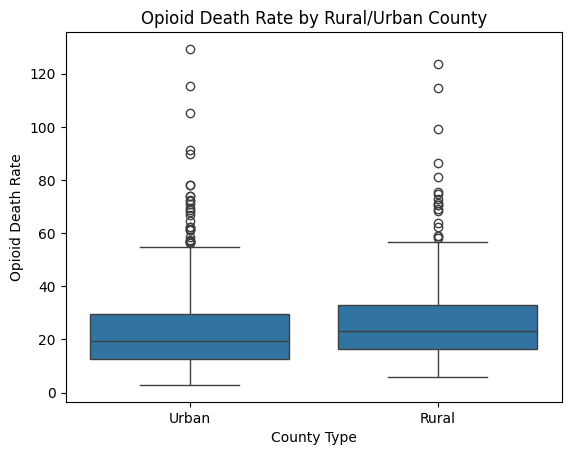

In [63]:
sns.boxplot(x="Rural", y="Crude Rate", data=rucc_death_df)
plt.title("Opioid Death Rate by Rural/Urban County")
plt.xlabel("County Type")
plt.ylabel("Opioid Death Rate")

In [8]:
# set to True if we want to refresh CDC data source
REFRESH_OPIOID_SOURCE = False 

if REFRESH_OPIOID_SOURCE: 
    for i in range(2006, 2021):
        print(f"at: {i}")
        df = pd.read_html(f"https://www.cdc.gov/drugoverdose/rxrate-maps/county{i}.html")[0]
        df['year'] = i
        df.to_csv(f"./data/opioid_rx/{i}.csv")

l = [pd.read_csv(f"./data/opioid_rx/{file}") for file in os.listdir("./data/opioid_rx/")]
df = pd.concat(l)
df = pd.concat(l)
df["Opioid Dispensing Rate per 100"] = (
    df["Opioid Dispensing Rate per 100"].replace("–", np.nan).astype("float32")
)
df

EmptyDataError: No columns to parse from file